1. Fashion MNIST 데이터 정규화를 위한 Mean 과 Std 값찾기
---

In [15]:
import os
from pathlib import Path
import torch
from torchvision import datasets, transforms

BASE_PATH = r"C:\Users\HwanHui\git\link_dl"

def calculate_fashion_mnist_mean_std():
    data_path = os.path.join(BASE_PATH, "_00_data", "j_fashion_mnist")
    f_mnist_train = datasets.FashionMNIST(data_path, train=True, download=True, transform=transforms.ToTensor())
    
    imgs = torch.stack([img for img, _ in f_mnist_train], dim=3)
    mean = imgs.view(1, -1).mean(dim=-1)
    std = imgs.view(1, -1).std(dim=-1)
    
    print(f"Fashion MNIST Mean: {mean.item()}")
    print(f"Fashion MNIST Std: {std.item()}")

if __name__ == "__main__":
    calculate_fashion_mnist_mean_std()

Fashion MNIST Mean: 0.28604063391685486
Fashion MNIST Std: 0.3530242443084717


Fashion MNIST 데이터셋의 정규화를 위해 훈련 데이터셋의 이미지를 텐서로 변환하고, 각 이미지의 평균과 표준편차 값을 계산함. 
torch.stack()을 사용하여 훈련 데이터셋의 모든 이미지를 하나의 텐서로 쌓고, 이를 view()와 mean() 및 std() 메서드를 사용하여 평균과 표준편차를 계산함.

Fashion MNIST Mean: 0.2861253023147583

Fashion MNIST Std: 0.3529607057571411

2. Fashion MNIST 데이터에 대하여 CNN 학습시키기
---

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms, datasets
import torchvision.models as models
import wandb
from torchvision.models import ResNet18_Weights

wandb.init(project="fashion-mnist")

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

train_dataset = datasets.FashionMNIST(
    root="./data", train=True, transform=transform, download=True
)
test_dataset = datasets.FashionMNIST(
    root="./data", train=False, transform=transform, download=True
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

def save_model(model, epoch, filename="best_model.pth"):
    torch.save(model.state_dict(), filename)

def early_stopping(patience, val_loss_history):
    if len(val_loss_history) > patience:
        recent_losses = val_loss_history[-(patience + 1):-1]
        if val_loss_history[-1] > min(recent_losses) * 1.05:
            return True
    return False

def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10, patience=5):
    best_val_loss = float('inf')
    val_loss_history = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss /= len(test_loader)
        val_acc = val_correct / val_total
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

        val_loss_history.append(val_loss)
        if early_stopping(patience, val_loss_history):
            print(f"Early stopping at epoch {epoch + 1} due to no improvement.")
            break

        wandb.log({"Epoch": epoch + 1, "Loss": epoch_loss, "Accuracy": epoch_acc, "Val Loss": val_loss,
                   "Val Accuracy": val_acc})

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            save_model(model, epoch + 1)

train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=5, patience=5)

Accuracy,▁▅▆▇█
Epoch,▁▃▅▆█
Loss,█▄▃▂▁
Val Accuracy,▃▁▆██
Val Loss,▆█▂▁▃
Accuracy,0.9812
Epoch,5
Loss,0.05323
Val Accuracy,0.9439
Val Loss,0.18012


Epoch 1/10, Loss: 0.2537, Accuracy: 0.9101
Validation Loss: 0.2001, Validation Accuracy: 0.9276
Epoch 2/10, Loss: 0.1468, Accuracy: 0.9470
Validation Loss: 0.1712, Validation Accuracy: 0.9379
Epoch 3/10, Loss: 0.1060, Accuracy: 0.9613
Validation Loss: 0.1605, Validation Accuracy: 0.9442
Epoch 4/10, Loss: 0.0735, Accuracy: 0.9738
Validation Loss: 0.1615, Validation Accuracy: 0.9484
Epoch 5/10, Loss: 0.0488, Accuracy: 0.9831
Validation Loss: 0.1840, Validation Accuracy: 0.9446
Early stopping at epoch 5 due to no improvement.


사용한 하이퍼파라미터
- Learning Rate: 0.0001
- Batch Size: 64
- Early Stop Patience: 5
- Weight Decay: 0.0001
- Normalization Type: transforms.Normalize((0.5,), (0.5,))

torchinfo 모듈 사용한 모델 구조 출력

In [18]:
from torchinfo import summary

model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

model.load_state_dict(torch.load("best_model.pth", weights_only=True))
model.eval()

summary(model, input_size=(64, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [64, 10]                  --
├─Conv2d: 1-1                            [64, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [64, 64, 112, 112]        128
├─ReLU: 1-3                              [64, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [64, 64, 56, 56]          --
├─Sequential: 1-5                        [64, 64, 56, 56]          --
│    └─BasicBlock: 2-1                   [64, 64, 56, 56]          --
│    │    └─Conv2d: 3-1                  [64, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-2             [64, 64, 56, 56]          128
│    │    └─ReLU: 3-3                    [64, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [64, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-5             [64, 64, 56, 56]          128
│    │    └─ReLU: 3-6                    [64, 64, 56, 56]          --
│

3. 학습 완료된 모델로 테스트 데이터 Accuracy 확인하기
---

In [19]:
model.load_state_dict(torch.load("best_model.pth", weights_only=True))
model = model.to(device)
model.eval()

correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 94.42%


4. 샘플 테스트 데이터 분류 예측 결과 확인하기
---

C:\Users\HwanHui\AppData\Local\Temp\ipykernel_32012\845672332.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))
Clippi

Image 1: Correct prediction!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9764706].


Image 2: Correct prediction!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8666667].


Image 3: Incorrect prediction. Label: 0, Predicted: 8


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.96862745].


Image 4: Correct prediction!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9607843].


Image 5: Correct prediction!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9843137].


Image 6: Correct prediction!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.92156863].


Image 7: Correct prediction!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.92156863].


Image 8: Correct prediction!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.92941177].


Image 9: Correct prediction!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9843137].


Image 10: Correct prediction!


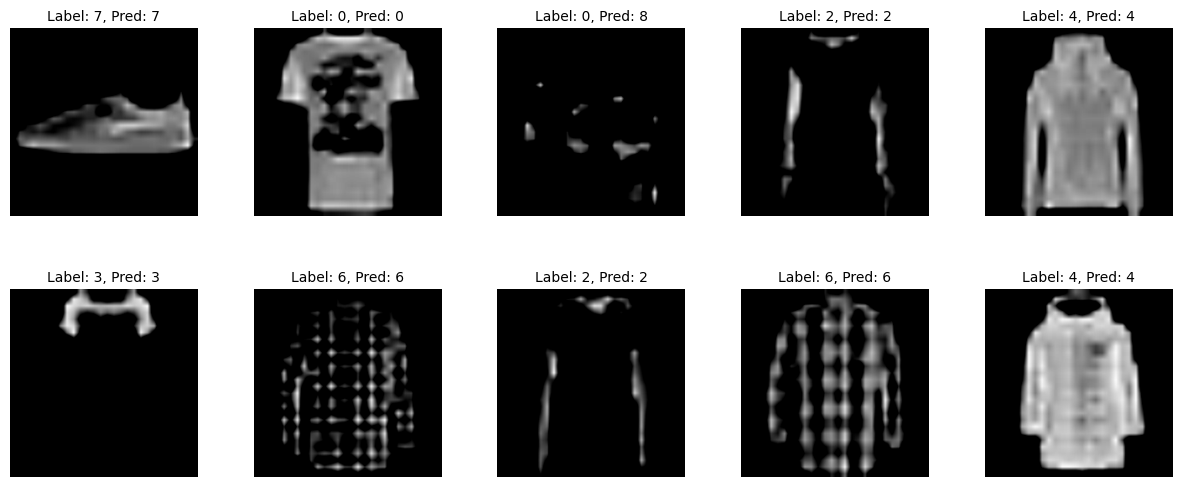

In [66]:
import random
import matplotlib.pyplot as plt
import torch
from torchvision import models, datasets, transforms
from torch import nn

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

train_dataset = datasets.FashionMNIST(
    root="./data", train=True, transform=transform, download=True
)
test_dataset = datasets.FashionMNIST(
    root="./data", train=False, transform=transform, download=True
)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

model.load_state_dict(torch.load("best_model.pth"))

def select_random_images():
    random_indices = random.sample(range(len(test_dataset)), 10)
    selected_images = [test_dataset[i] for i in random_indices]
    return selected_images

def display_and_predict(model, selected_images):
    model.eval()
    plt.figure(figsize=(15, 6))
    for i, (img, label) in enumerate(selected_images):
        img_tensor = img.unsqueeze(0).to(device)
        output = model(img_tensor)
        _, predicted = torch.max(output, 1)

        plt.subplot(2, 5, i+1)
        plt.imshow(img.permute(1, 2, 0))
        plt.title(f"Label: {label}, Pred: {predicted.item()}", fontsize=10)
        plt.axis('off')

        if label == predicted.item():
            print(f"Image {i+1}: Correct prediction!")
        else:
            print(f"Image {i+1}: Incorrect prediction. Label: {label}, Predicted: {predicted.item()}")

    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    plt.show()

def main():
    selected_images = select_random_images()
    display_and_predict(model, selected_images)

if __name__ == "__main__":
    main()


해당 이미지는 0: T-shirt/top 이 8: Bag 로 분류된 사례입니다.
예측이 잘못된 이유는 이미지 상의 옷 형태가 거의 보이지 않아서 모델이 제대로 분류하지 못한 것으로 보입니다.
이미지의 색상은 흑백이고 이미지 상의 옷의 모습 대부분이 검은색으로 나타나고 있어 원본 옷의 특징이 거의 드러나있지 않습니다.
이로 인해 옷의 형태나 세부적인 디테일을 인식하기 어려워 모델이 8: Bag 로 잘못 예측한 것으로 추정됩니다.

숙제 후기
---

이번 과제를 통해 이미지 분류 모델을 학습시키는 전 과정을 직접 경험하면서 많은 것을 배울 수 있었습니다. 우선, FashionMNIST 데이터를 모델 학습에 적합한 형태로 가공하는 데이터 전처리 과정을 진행하면서, 데이터의 크기나 채널 수를 조정하는 것이 모델 성능에 중요한 영향을 미친다는 것을 실감할 수 있었습니다.
모델 학습 과정에서는 ResNet 모델을 활용하여 빠르게 성능을 개선할 수 있었습니다. 기본적으로 제공되는 모델을 주어진 데이터셋에 적합하도록 조정할 수 있다는 점이 매우 유용하게 느껴졌습니다. Adam Optimizer를 사용하면서 딥러닝 학습에서 Adam Optimizer의 효과를 직접 확인할 수 있었고, 학습 속도와 성능 모두에서 뛰어난 성능을 보였습니다.
학습 후 테스트 데이터에 대해 예측을 진행하면서, 그 중 일부 이미지는 모델이 제대로 인식하지 못한 이유를 이미지의 왜곡이나 불완전한 특성으로 설명할 수 있었으며, 이는 모델을 더 잘 이해하는 데 큰 도움이 되었습니다.
이번 과제를 통해 딥러닝 모델 학습의 전체적인 흐름을 보다 잘 이해할 수 있었고, 다양한 실험을 통해 모델 성능을 개선하는 방법을 배우게 되어 매우 유익한 경험이었습니다.